In [43]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np

root_dir = 'img_align_celeba'
img_size = (128, 128)

# Define the transformation. You might want to transform the images (e.g., resizing, normalization) for your specific task.
transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    # transforms.Resize((128, 160)),
    transforms.ToTensor(), # Convert images to tensor
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize images
])

dataset = ImageFolder(root_dir, transform=transform)
subset = Subset(dataset, range(100))

batch_size = 1
loader = DataLoader(subset, batch_size=batch_size, shuffle=False)

outside_weight = 0.4
# celeba_dataset = CelebA(root=root_dir, split='train', transform=transform, download=False)


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoEncoder(nn.Module):
    """Abstract AutoEncoder class"""
    encoder: nn.Module
    decoder: nn.Module
    
    def get_latent_size(self, img_size=img_size, n_channels=3):
        """Return the latent dimension of the AutoEncoder given an input image size."""
        
        dummy = torch.zeros((n_channels,) + img_size).unsqueeze(0).to(device)
        return self.encoder(dummy).squeeze(0).shape
    
    
class SaliencyAutoEncoder(nn.Module):
    def __init__(self):
        super(SaliencyAutoEncoder, self).__init__()
        
        self.saliency_mapper = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # 64x64
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(16, 1, 3, stride=2, padding=1), # 8x8
        )
        
        self.high_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 8x8
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.low_res = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1), # 16x16
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=2, padding=1), # 8x8
            nn.ReLU(True),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), # 4x4
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=1, padding=1, output_padding=0),
            nn.Sigmoid()
        )
        
        self.k = 32
        
    def fold(self, patches):
        # Parameters for patches
        batch_size = patches.shape[0]
        channels = 3
        image_size = 128
        patch_size = 16
        stride = 16  # stride of 16 will ensure non-overlapping patches
        
        patches = patches.reshape((batch_size, channels, 8 * 8, patch_size * patch_size))

        # Permute to bring patches to the last but one dimension and flatten patches
        patches = patches.permute(0, 1, 3, 2).contiguous()
        patches = patches.view(batch_size, channels * patch_size * patch_size, 8 * 8)

        # Calculate output size
        output_height = 8 * patch_size
        output_width = 8 * patch_size

        # Fold to reconstruct the image
        return F.fold(patches, output_size=(output_height, output_width), kernel_size=(patch_size, patch_size), stride=stride)

    
    def forward(self, x):
        saliency = self.saliency_mapper(x) # Nx1x8x8
        saliency = torch.flatten(saliency, start_dim=1, end_dim=-1) # Nx64
                
        topk = torch.topk(saliency, self.k, dim=-1)
        fg_mask = torch.zeros_like(saliency, dtype=torch.bool, device=device)
        fg_mask[torch.arange(fg_mask.size(0)).unsqueeze(1), topk.indices] = True
        fg_mask = fg_mask.reshape((fg_mask.size(0), 8, 8))
        bg_mask = ~fg_mask
                
        # Parameters for patches
        image_size = 128
        patch_size = 16
        stride = 16  # stride of 16 will ensure non-overlapping patches

        # Extract patches
        # [batch_size, channels, patch_i, patch_j, patch_size, patch_size]
        patches = x.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
        patches = patches.permute((0, 2, 3, 1, 4, 5))
                
        fg = patches[fg_mask, ...] # [batch_size, k, C, P, P]
        bg = patches[bg_mask, ...]  # [batch_size, 64 - k, C, P, P]
                
        r_fg = self.high_res(fg) # TODO: PE
        r_bg = self.low_res(bg)
        
        r_patches = torch.zeros_like(patches, device=device)
        r_patches[fg_mask] = r_fg
        r_patches[bg_mask] = r_bg
        
        r_patches = r_patches.permute((0, 3, 1, 2, 4, 5))
        
        return self.fold(r_patches)
        
        # return reconstructed
    
    
class FCAutoEncoder(AutoEncoder):
    def __init__(self):
        super(FCAutoEncoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(49152, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 49152),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, 128, 128))
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class CNNAutoencoder(AutoEncoder):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
                
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1), # Input channels = 3 (RGB), Output channels = 16
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7) # No padding
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Using Sigmoid to ensure the output is between 0 and 1
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
model = SaliencyAutoEncoder().to(device)
model(torch.zeros((64, 3, 128, 128)).cuda())

tensor([[[[0.5014, 0.4996, 0.5023,  ..., 0.4995, 0.5022, 0.5066],
          [0.5049, 0.5040, 0.5045,  ..., 0.5045, 0.5030, 0.5126],
          [0.5048, 0.5009, 0.5055,  ..., 0.5008, 0.5057, 0.5113],
          ...,
          [0.4666, 0.4736, 0.4710,  ..., 0.4737, 0.4705, 0.4767],
          [0.4612, 0.4672, 0.4626,  ..., 0.4672, 0.4638, 0.4744],
          [0.4599, 0.4752, 0.4713,  ..., 0.4751, 0.4716, 0.4804]],

         [[0.4780, 0.4811, 0.4791,  ..., 0.4818, 0.4794, 0.4772],
          [0.4757, 0.4743, 0.4764,  ..., 0.4739, 0.4761, 0.4635],
          [0.4737, 0.4773, 0.4729,  ..., 0.4781, 0.4739, 0.4678],
          ...,
          [0.5356, 0.5369, 0.5386,  ..., 0.5371, 0.5359, 0.5365],
          [0.5370, 0.5389, 0.5375,  ..., 0.5389, 0.5357, 0.5409],
          [0.5357, 0.5346, 0.5358,  ..., 0.5346, 0.5343, 0.5376]],

         [[0.5005, 0.5107, 0.5114,  ..., 0.5106, 0.5111, 0.5071],
          [0.4980, 0.5101, 0.5119,  ..., 0.5100, 0.5124, 0.5091],
          [0.4964, 0.5095, 0.5096,  ..., 0

In [46]:
from tqdm import tqdm


# Model instantiation
model = SaliencyAutoEncoder().to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 100
total_data = len(subset)

In [47]:

import torch.nn.functional as F
# from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage
from facenet_pytorch import MTCNN

mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

def tensor_to_img(t):
    img_tensor = (t * 255).byte()
    to_pil_image = ToPILImage()
    img = to_pil_image(img_tensor)

    return img
    
def scale_outside_bbox(tensor, bbox, scale_factor):
    bbox = bbox.long()
    # Create masks for each box
    mask = torch.full_like(tensor, scale_factor)
    x_min, y_min, x_max, y_max = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    
    for i in range(tensor.shape[0]): # See if we can batch this later
        mask[i, y_min[i]:y_max[i], x_min[i]:x_max[i]] = 1
    
    # print(x_min.size())
    
    
    # Create indices for batched masks
    # batch_indices = torch.arange(tensor.shape[0]).unsqueeze(1).unsqueeze(2)
    
    # Update masks using advanced indexing
    # mask[batch_indices, y_min.unsqueeze(1):y_max.unsqueeze(1), x_min.unsqueeze(1):x_max.unsqueeze(1)] = 1
    # mask[torch.arange(tensor.shape[0]), y_min:y_max, x_min:x_max] = 1

    # C, H, W = tensor.shape
    # x_min, y_min, x_max, y_max = map(int, bbox)
    
    # mask = torch.full_like(tensor, scale_factor)
    # mask[:, y_min:y_max, x_min:x_max] = 1

    tensor_masked = tensor * mask
    
    return tensor_masked


def inside_outside(tensor, bbox):
    bbox = bbox.long()
    # Create masks for each box
    mask = torch.full_like(tensor, 0)
    x_min, y_min, x_max, y_max = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    # x_min, y_min, x_max, y_max = torch.ones((tensor.shape[0], )) * 30, torch.ones((tensor.shape[0], )) * 30, torch.ones((tensor.shape[0], )) * 60, torch.ones((tensor.shape[0], )) * 60
    # x_min, y_min, x_max, y_max = x_min.long(), y_min.long(), x_max.long(), y_max.long()
        
    for i in range(tensor.shape[0]): # See if we can batch this later        
        mask[i, :, y_min[i]:y_max[i], x_min[i]:x_max[i]] = 1
                        
    return tensor * mask, tensor * (1 - mask)
    
    # # print(x_min.size())
    
    
    # # Create indices for batched masks
    # # batch_indices = torch.arange(tensor.shape[0]).unsqueeze(1).unsqueeze(2)
    
    # # Update masks using advanced indexing
    # # mask[batch_indices, y_min.unsqueeze(1):y_max.unsqueeze(1), x_min.unsqueeze(1):x_max.unsqueeze(1)] = 1
    # # mask[torch.arange(tensor.shape[0]), y_min:y_max, x_min:x_max] = 1

    # # C, H, W = tensor.shape
    # # x_min, y_min, x_max, y_max = map(int, bbox)
    
    # # mask = torch.full_like(tensor, scale_factor)
    # # mask[:, y_min:y_max, x_min:x_max] = 1

    # tensor_masked = tensor * mask
    
    # return tensor_masked


def objective(source, reconstruction):
    # img = tensor_to_img(source)
    boxes, probs = mtcnn.detect(source.permute(0, 2, 3, 1) * 255)

    bbox = torch.from_numpy(np.floor(boxes[:, 0, :]).astype(int))
        
    ins_s, out_s = inside_outside(source, bbox)
    ins_r, out_r = inside_outside(reconstruction, bbox)
    
    # print(ins_s.sum(), out_s.sum())
        
    loss = F.mse_loss(ins_s, ins_r, reduction='sum')
    loss += F.mse_loss(out_s, out_r, reduction='sum') * outside_weight
        
    # scaled_source = scale_outside_bbox(source, bbox, 0.2)
    # scaled_reconstruction = scale_outside_bbox(reconstruction, bbox, 0.1)
    
    # plt.imshow(ins_r.squeeze(0).permute((1, 2, 0)))

    # loss = F.mse_loss(scaled_source, scaled_reconstruction)
    
    return loss

/scratch/ondemand28/qiuandr1/envs/csc413/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
objective(dataset[0][0].unsqueeze(0), dataset[0][0].unsqueeze(0))

tensor(0.)

In [49]:
# Training loop
for epoch in range(num_epochs):
    for data in loader:
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        outputs = model(img)

        loss = criterion(outputs, img)
        # loss = objective(img, outputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if not i % 25:
        #     print(f'Batch {i}, Loss: {loss.item():.4f}')
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 684.5068
Epoch [2/100], Loss: 139.8981
Epoch [3/100], Loss: 99.7990
Epoch [4/100], Loss: 84.0862
Epoch [5/100], Loss: 74.1049
Epoch [6/100], Loss: 65.1102
Epoch [7/100], Loss: 60.0889
Epoch [8/100], Loss: 55.0638
Epoch [9/100], Loss: 50.2244
Epoch [10/100], Loss: 46.5080
Epoch [11/100], Loss: 43.4835
Epoch [12/100], Loss: 40.7862
Epoch [13/100], Loss: 38.6201
Epoch [14/100], Loss: 36.7779
Epoch [15/100], Loss: 35.3076
Epoch [16/100], Loss: 34.0881
Epoch [17/100], Loss: 33.0948
Epoch [18/100], Loss: 32.2437
Epoch [19/100], Loss: 31.5001
Epoch [20/100], Loss: 30.7770
Epoch [21/100], Loss: 30.0794
Epoch [22/100], Loss: 29.4096
Epoch [23/100], Loss: 28.8186
Epoch [24/100], Loss: 28.2428
Epoch [25/100], Loss: 27.6099
Epoch [26/100], Loss: 26.9471
Epoch [27/100], Loss: 26.2407
Epoch [28/100], Loss: 25.6229
Epoch [29/100], Loss: 25.1322
Epoch [30/100], Loss: 24.7586
Epoch [31/100], Loss: 24.4703
Epoch [32/100], Loss: 24.2337
Epoch [33/100], Loss: 24.0229
Epoch [34/100], L

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def show_pair(img):
    plt.figure(figsize=(10, 5)) 
    plt.subplot(121)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    
    reconstruction = model(img.to(device).unsqueeze(0)).squeeze(0).to('cpu').detach()
    plt.subplot(122)
    plt.imshow(torch.permute(reconstruction, (1, 2, 0)))
     # Adjust display size as needed
    # Transpose the image dimensions from (C, H, W) to (H, W, C) for plotting
    # plt.imshow(np.transpose(img, (1, 2, 0)))
    # plt.axis('off')  # Hide axes ticks
    # plt.show()
    

# def imshow(img):
#     # Assuming img is a PyTorch tensor of shape (C, H, W)
#     img = img.detach().numpy()  # Convert to numpy array
#     plt.figure(figsize=(5, 5))  # Adjust display size as needed
#     # Transpose the image dimensions from (C, H, W) to (H, W, C) for plotting
#     plt.imshow(np.transpose(img, (1, 2, 0)))
#     plt.axis('off')  # Hide axes ticks
#     plt.show()

In [55]:

# mtcnn.detect(dataset[0][0].unsqueeze(0).permute(0, 2, 3, 1) * 255)

# torch.save(model, f'two-resolution, outside={outside_weight}.pt')
torch.save(model, f'two-resolution, normal-l2.pt')

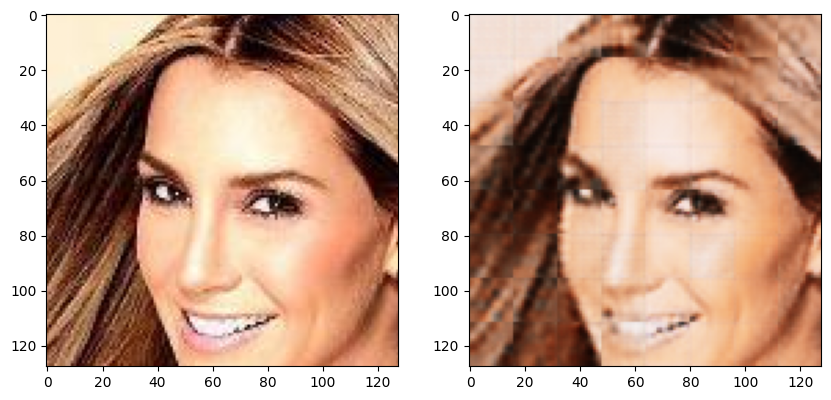

In [54]:
show_pair(dataset[0][0])

# print(model.get_latent_size())